In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import YouTubeVideo
from scipy.stats import norm
from sklearn.metrics import mean_squared_error, mean_absolute_error,explained_variance_score
from statistics import variance

In [2]:
var_all=np.array([43.3189,291.97,2938.77])
var_all
jj = var_all*np.eye(3)
jj


array([[  43.3189,    0.    ,    0.    ],
       [   0.    ,  291.97  ,    0.    ],
       [   0.    ,    0.    , 2938.77  ]])

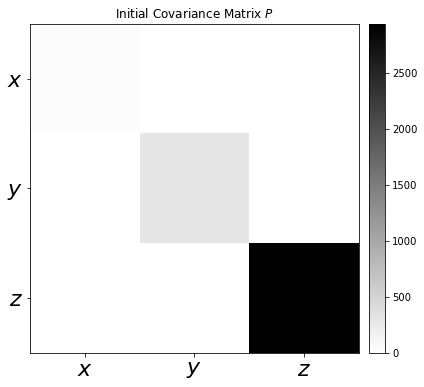

In [3]:

P =jj

fig = plt.figure(figsize=(6, 6))
im = plt.imshow(P, interpolation="none", cmap=plt.get_cmap('binary'))
plt.title('Initial Covariance Matrix $P$')
ylocs, ylabels = plt.yticks()
# set the locations of the yticks
plt.yticks(np.arange(1))
# set the locations and labels of the yticks
plt.yticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)

xlocs, xlabels = plt.xticks()
# set the locations of the yticks
plt.xticks(np.arange(1))
# set the locations and labels of the yticks
plt.xticks(np.arange(3),('$x$', '$y$', '$z$'), fontsize=22)
from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(plt.gca())
cax = divider.append_axes("right", "5%", pad="3%")
plt.colorbar(im, cax=cax)


plt.tight_layout()

## Dynamic Matrix

In [4]:
dt = 1.0/100.0 # Time Step between Filter Steps, 100Hz

A = np.matrix([[1.0, 0.0, 0.0],
              [0.0, 1.0, 0.0],
              [0.0, 0.0, 1.0]])
print(A.shape)

(3, 3)


## Measurement Matrix

Here you can determine, which of the states is covered by a measurement. In this example, the position ($x$ and $y$) is measured.

In [5]:
H = np.matrix([[1.0, 0.0, 0.0],
               [0.0, 1.0, 0.0],
               [0.0, 0.0, 1.0]])
print(H, H.shape)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (3, 3)


## Measurement Noise Covariance Matrix $R$

In [6]:
rp = 1  # Noise of Position Measurement
R = np.matrix([[rp, 0.0, 0.0],
               [0.0, rp, 0.0],
               [0.0, 0.0, rp]])
print(R, R.shape)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (3, 3)


## Process Noise Covariance Matrix $Q$ for CA Model

The Position of the ball can be influenced by a force (e.g. wind), which leads to an acceleration disturbance (noise). This process noise has to be modeled with the process noise covariance matrix Q.

To easily calcualte Q, one can ask the question: How the noise effects my state vector? For example, how the acceleration change the position over one timestep dt.

One can calculate Q as

$$Q = G\cdot G^T \cdot \sigma_a^2$$

with $G = \begin{bmatrix}0.5dt^2 & 0.5dt^2 & 0.5dt^2 & dt & dt & dt & 1.0 &1.0 & 1.0\end{bmatrix}^T$ and $\sigma_a$ as the acceleration process noise.

#### Symbolic Calculation

In [7]:

Q = np.eye(3)

print(Q.shape)
Q

(3, 3)


array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Identity Matrix

In [8]:
I = np.eye(3)
print(I, I.shape)

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]] (3, 3)


## Measurements

Synthetically created Data of the Position of the Ball

In [9]:
data = pd.read_csv('weather-raw_2020.csv')
data=data.fillna(0)
data.head()

,Date,Temp,Humidity (%),Dew Point (Celcius * 10),Pressure (mBar),Mean wind speed (knots * 10),Average wind bearing (degrees),Sunshine (hours * 100),Rainfall (mm * 1000)
0,6/30/1995,30.5,36.0,140.0,1013.0,13.0,315.0,50,0
1,6/30/1995,31.1,41.0,163.0,1013.0,12.0,315.0,51,0
2,6/30/1995,32.2,43.0,181.0,1013.0,2.0,315.0,50,0
3,6/30/1995,32.7,41.0,178.0,1013.0,8.0,225.0,51,0
4,6/30/1995,32.2,43.0,181.0,1012.0,17.0,0.0,51,0


In [10]:
date=pd.to_datetime(data['Date']).values

In [11]:
frames=[data['Temp'],data['Humidity (%)'],data['Dew Point (Celcius * 10)'],data['Pressure (mBar)'],data['Mean wind speed (knots * 10)'],data['Average wind bearing (degrees)']]

In [12]:
data=pd.concat(frames, axis=1)
Xm=data['Temp'].T.values
Xm.shape

(439229,)

m = Measurements, r= real values (unknown, just for plotting)

In [13]:
[Xm, Ym, Zm, Xr, Yr, Zr] = data.T.values
Ym.shape

(439229,)

(-254.76658645034823, 389.2334135496518)

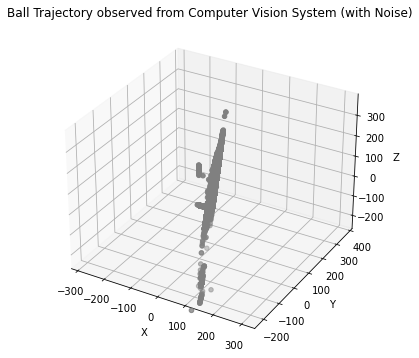

In [14]:
fig = plt.figure(figsize=(12,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(Xm, Ym, Zm, c='gray')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('Ball Trajectory observed from Computer Vision System (with Noise)')

#ax.w_xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))

# Axis equal
max_range = np.array([Xm.max()-Xm.min(), Ym.max()-Ym.min(), Zm.max()-Zm.min()]).max() / 3.0
mean_x = Xm.mean()
mean_y = Ym.mean()
mean_z = Zm.mean()
ax.set_xlim(mean_x - max_range, mean_x + max_range)
ax.set_ylim(mean_y - max_range, mean_y + max_range)
ax.set_zlim(mean_z - max_range, mean_z + max_range)
#plt.savefig('BallTrajectory-Computervision.png', dpi=150, bbox_inches='tight')

In [15]:
measurements = np.vstack((Xm,Ym,Zm))
m = len(measurements[0]) # short it
print(measurements.shape)

(3, 439229)


#### Initial State

In [16]:
x = np.matrix([30.5, 36, 140.0]).T
print(x, x.shape)

[[ 30.5]
 [ 36. ]
 [140. ]] (3, 1)


In [17]:
# Preallocation for Plotting
xt = []
yt = []
zt = []

Zx = []
Zy = []
Zz = []

Px = []
Py = []
Pz = []

Kx = []
Ky = []
Kz = []


## Kalman Filter

![Kalman Filter](Kalman-Filter-Step.png)

In [18]:

for filterstep in range(m):
    
    # Time Update (Prediction)
    # ========================
    # Project the state ahead
    x = A*x #+ B*u # we have no Control Input
    
    # Project the error covariance ahead
    P = A*P*A.T + Q    
    
    
    # Measurement Update (Correction)
    # ===============================
    # Compute the Kalman Gain
    S = H*P*H.T + R
    K = (P*H.T) * np.linalg.pinv(S)

    
    # Update the estimate via z
    Z = measurements[:,filterstep].reshape(H.shape[0],1)
    y = Z - (H*x)                            # Innovation or Residual
    x = x + (K*y)
    
    # Update the error covariance
    P = (I - (K*H))*P
    
   
    
    # Save states for Plotting
    xt.append(float(x[0]))
    yt.append(float(x[1]))
    zt.append(float(x[2]))
    
    Zx.append(float(Z[0]))
    Zy.append(float(Z[1]))
    Zz.append(float(Z[2]))
    
    Px.append(float(P[0,0]))
    Py.append(float(P[1,1]))
    Pz.append(float(P[2,2]))
   
    Kx.append(float(K[0,0]))
    Ky.append(float(K[1,0]))
    Kz.append(float(K[2,0]))
    

# Plots

## Estimated State

### Uncertainty

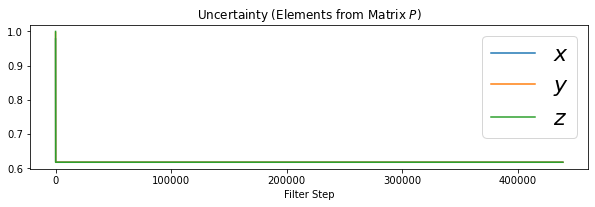

In [19]:
%matplotlib inline
fw=10 # figure width
fig = plt.figure(figsize=(fw,9))
plt.subplot(311)
plt.plot(range(len(measurements[0])),Px, label='$x$')
plt.plot(range(len(measurements[0])),Py, label='$y$')
plt.plot(range(len(measurements[0])),Pz, label='$z$')
plt.title('Uncertainty (Elements from Matrix $P$)')
plt.legend(loc='best',prop={'size':22})

plt.xlabel('Filter Step')
plt.ylabel('')
plt.legend(loc='best',prop={'size':22})

### Kalman Gains

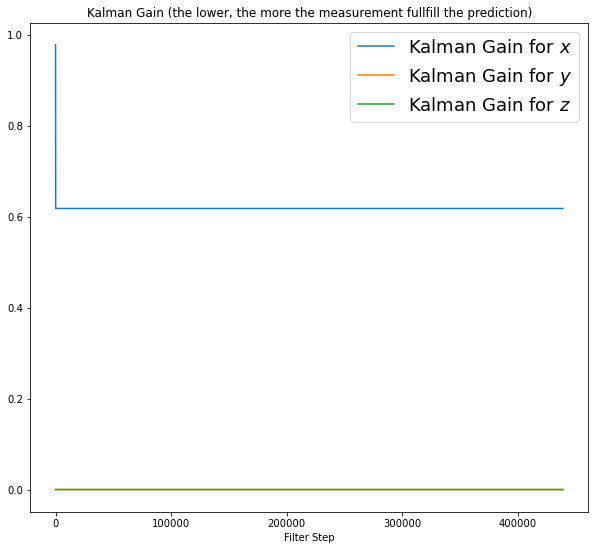

In [20]:
fig = plt.figure(figsize=(fw,9))
plt.plot(range(len(measurements[0])),Kx, label='Kalman Gain for $x$')
plt.plot(range(len(measurements[0])),Ky, label='Kalman Gain for $y$')
plt.plot(range(len(measurements[0])),Kz, label='Kalman Gain for $z$')

plt.xlabel('Filter Step')
plt.ylabel('')
plt.title('Kalman Gain (the lower, the more the measurement fullfill the prediction)')
plt.legend(loc='best',prop={'size':18});

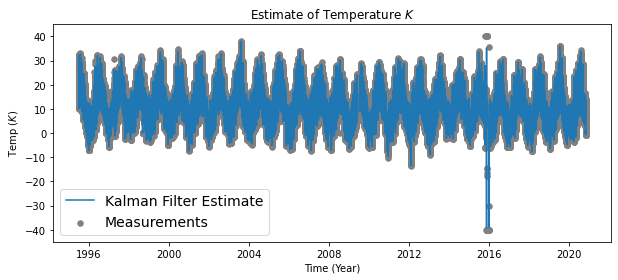

In [21]:
fig = plt.figure(figsize=(fw,4))

plt.plot(date,xt, label='Kalman Filter Estimate')
plt.scatter(date,Xm, label='Measurements', c='gray', s=30)
#plt.plot(Xr, Zr, label='Real')
plt.title('Estimate of Temperature $K$')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time (Year)')
plt.ylabel('Temp ($K$)')
plt.ylim(-45, 45);
plt.savefig('Kalman-Filter-Estimate of Temperature.png', dpi=72, bbox_inches='tight')

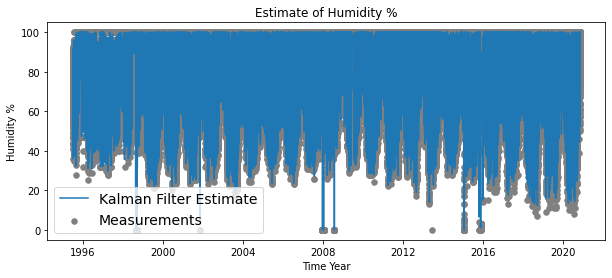

In [22]:
fig = plt.figure(figsize=(fw,4))

plt.plot(date,yt, label='Kalman Filter Estimate')
plt.scatter(date,Ym, label='Measurements', c='gray', s=30)
#plt.plot(Xr, Zr, label='Real')
plt.title('Estimate of Humidity %')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Year')
plt.ylabel('Humidity %')
plt.savefig('Kalman-Filter-Estimate of Humidity %.png', dpi=72, bbox_inches='tight')

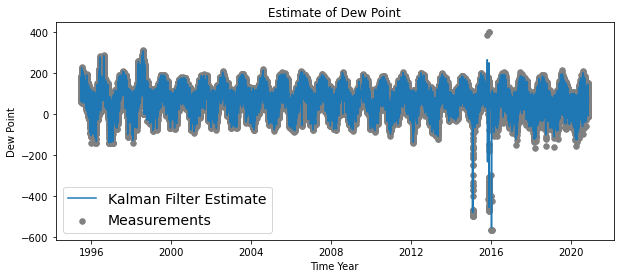

In [23]:
fig = plt.figure(figsize=(fw,4))

plt.plot(date,zt, label='Kalman Filter Estimate')
plt.scatter(date,Zm, label='Measurements', c='gray', s=30)
#plt.plot(Xr, Zr, label='Real')
plt.title('Estimate of Dew Point')
plt.legend(loc='best',prop={'size':14})
plt.xlabel('Time Year')
plt.ylabel('Dew Point')
plt.savefig('Kalman-Filter-Estimate of Dew Point.png', dpi=72, bbox_inches='tight')

# Conclusion

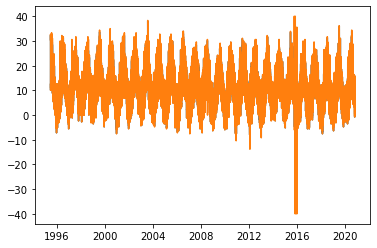

In [25]:
plt.plot(date,xt,date,Xm)

In [26]:
RMSE=mean_squared_error(Xm,xt, squared=False)

In [27]:
print(RMSE)

0.3497341951775569


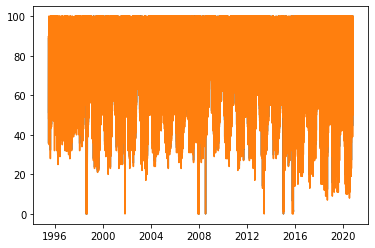

In [28]:
plt.plot(date,yt,date,Ym)

In [29]:
RMSE=mean_squared_error(Ym,yt, squared=False)

In [30]:
print(RMSE)

1.8771254817626482


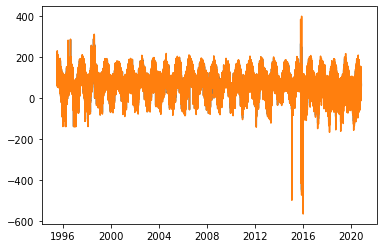

In [31]:
plt.plot(date,zt,date,Zm)

In [32]:
RMSE=mean_squared_error(Zm,zt, squared=False)
print(RMSE)

3.7496620423068725


In [33]:
Var_Temp=variance(Xm)
Var_Temp_KF=variance(xt)
print(Var_Temp,Var_Temp_KF)

43.31891699676156 42.99924466334011


In [34]:
Var_Humidity=variance(Ym)
Var_Humidity_KF=variance(yt)
print(Var_Humidity,Var_Humidity_KF)

291.97791472927383 282.75544321194684


In [35]:
Var_Dew_point=variance(Zm)
Var_Dew_point_KF=variance(zt)
print(Var_Dew_point,Var_Dew_point_KF)

2938.772391505238 2901.970960991861
